# **Actividad Serie de tiempo**

Gwyneth Blanco Durán

## **Datos y análisis descriptivo**

In [172]:
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from numpy import log
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import r2_score
import numpy as np

Para este ejercicio, se utilizaran los datos proporcionados para la empresa estadounidense Walmart.

In [173]:
walmartacc = yf.Ticker("WMT")

In [174]:
sns.set_theme()
sns.set_context("paper")

In [305]:
stock = 'WMT'
resolution = '1d'

Tomaremos los datos de hace 10 años atras, por lo tanto, tomaremos las observaciones desde el año 2014.

In [176]:
start_date = datetime(2014, 1, 1)
end_date = datetime.now()

In [177]:
def date_format(date_h):
    return date_h.strftime('%d/%m/%Y')

Observamos el contenido de nuestra base de datos

In [178]:
walmartacc_df = get_data(stock, start_date=start_date, end_date=end_date, interval=resolution, index_as_date=False)
walmartacc_df.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2014-01-02,26.240000,26.490000,26.166668,26.303333,21.054293,20634000,WMT
1,2014-01-03,26.270000,26.376667,26.173332,26.216667,20.984922,14872200,WMT
2,2014-01-06,26.286667,26.303333,25.930000,26.070000,20.867525,21840600,WMT
3,2014-01-07,26.056667,26.283333,25.973333,26.150000,20.931561,15036900,WMT
4,2014-01-08,26.166668,26.170000,25.866667,25.943333,20.766130,17865600,WMT


Realizamos un analisis de las variables numéricas que estan en nuestros datos.

In [179]:
walmartacc_df.describe()

,date,open,high,low,close,adjclose,volume
count,2698,2698.000000,2698.000000,2698.000000,2698.000000,2698.000000,2.698000e+03
mean,2019-05-12 04:25:47.813195008,37.309190,37.603471,37.032025,37.321139,34.622624,2.384270e+07
min,2014-01-02 00:00:00,18.796667,19.020000,18.766666,18.806667,15.728047,6.287500e+06
25%,2016-09-06 06:00:00,25.587500,25.715000,25.457500,25.590000,21.199251,1.625092e+07
50%,2019-05-13 12:00:00,34.555000,34.951666,34.311666,34.725000,31.463522,2.040660e+07
75%,2022-01-12 18:00:00,47.280833,47.659166,46.931667,47.311666,45.288038,2.700540e+07
max,2024-09-20 00:00:00,80.839996,81.019997,80.139999,80.599998,80.599998,2.426943e+08
std,NaN,12.581768,12.674798,12.479497,12.585463,13.671116,1.381607e+07


Ahora, observaremos el comportamiento durante el transcurso de 10 años de nuestra serie de tiempo para la empresa Walmart.


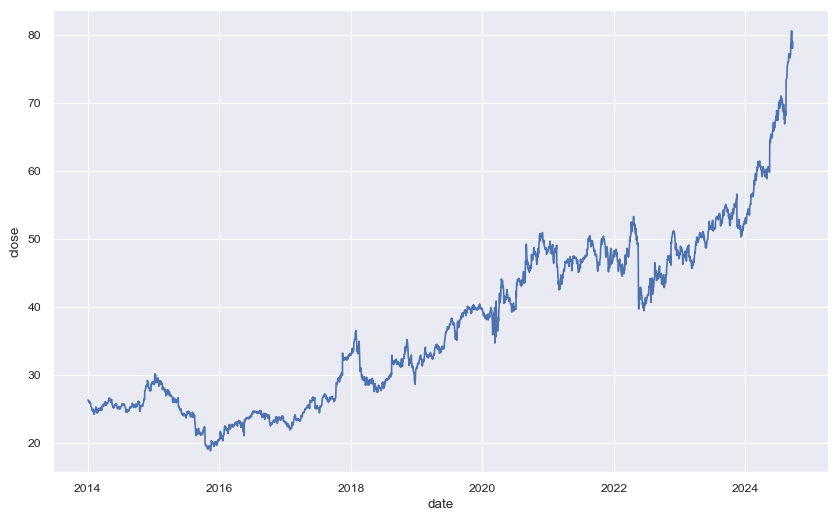

In [180]:
sns.lineplot(data=walmartacc_df, x=walmartacc_df.date, y=walmartacc_df.close);

Se puede observar un aumento a través de los años en el rendimiento financiero de la empresa Walmart, más adelante analizaremos si la serie es estacionaria o no.

Realizaremos un paso importante para el desarrollo del ejercicio; identificar los mejores parámetros para optimizar los criterios AIC, BIC y HQIC. Este proceso es fundamental, ya que elegir los parámetros óptimos ayuda a mejorar el ajuste del modelo. 

In [181]:
model_scores = []

for d in range(1, 3):
    for ari in range(1, 3):
        for maj in range(1, 3):
                # Ajuste del modelo ARIMA
                arima_obj = ARIMA(walmartacc_df['adjclose'].tolist(), order=(ari, d, maj))
                arima_obj_fit = arima_obj.fit()

                # Almacenar los valores de AIC, BIC, HQIC y los parámetros
                model_scores.append([ari, d, maj, arima_obj_fit.aic, arima_obj_fit.bic, arima_obj_fit.hqic])

Se realizó un dataframe con los mejores scores.

In [182]:
columns = ['AR', 'D', 'MA', 'AIC', 'BIC', 'HQIC']
model_scores_df = pd.DataFrame(model_scores, columns=columns)
model_scores_df

,AR,D,MA,AIC,BIC,HQIC
0,1,1,1,3700.908090,3718.607776,3707.309187
1,1,1,2,3702.931429,3726.531011,3711.466225
2,2,1,1,3702.903120,3726.502701,3711.437916
3,2,1,2,3695.369656,3724.869133,3706.038151
4,1,2,1,3700.834886,3718.533460,3707.235701
5,1,2,2,3706.017066,3729.615164,3714.551486
6,2,2,1,3702.824196,3726.422293,3711.358616
7,2,2,2,3700.052939,3729.550562,3710.720965


Se obtuvo las columnas con los mejores valores.

In [183]:
best_aic = model_scores_df['AIC'].min()
best_bic = model_scores_df['BIC'].min()
best_hqic = model_scores_df['HQIC'].min()

#mejores valores de AIC, BIC y HQIC
best_aic_row = model_scores_df[model_scores_df['AIC'] == best_aic]
best_bic_row = model_scores_df[model_scores_df['BIC'] == best_bic]
best_hqic_row = model_scores_df[model_scores_df['HQIC'] == best_hqic]

print("Mejor AIC:")
print(best_aic_row)

print("\nMejor BIC:")
print(best_bic_row)

print("\nMejor HQIC:")
print(best_hqic_row)


Mejor AIC:
   AR  D  MA          AIC          BIC         HQIC
3   2  1   2  3695.369656  3724.869133  3706.038151

Mejor BIC:
   AR  D  MA          AIC         BIC         HQIC
4   1  2   1  3700.834886  3718.53346  3707.235701

Mejor HQIC:
   AR  D  MA          AIC          BIC         HQIC
3   2  1   2  3695.369656  3724.869133  3706.038151


In [184]:

min_aic_idx = model_scores_df['AIC'].idxmin()
min_bic_idx = model_scores_df['BIC'].idxmin()
min_hqic_idx = model_scores_df['HQIC'].idxmin()

# Obtener los valores mínimos de AIC, BIC y HQIC
min_aic = model_scores_df.loc[min_aic_idx, ['AR', 'D', 'MA', 'AIC']]
min_bic = model_scores_df.loc[min_bic_idx, ['AR', 'D', 'MA', 'BIC']]
min_hqic = model_scores_df.loc[min_hqic_idx, ['AR', 'D', 'MA', 'HQIC']]

mejores_modelos = pd.DataFrame({
    'Métrica': ['AIC', 'BIC', 'HQIC'],
    'AR': [min_aic['AR'], min_bic['AR'], min_hqic['AR']],
    'D': [min_aic['D'], min_bic['D'], min_hqic['D']],
    'MA': [min_aic['MA'], min_bic['MA'], min_hqic['MA']],
    'Valor': [min_aic['AIC'], min_bic['BIC'], min_hqic['HQIC']]
})
print(mejores_modelos)


  Métrica   AR    D   MA        Valor
0     AIC  2.0  1.0  2.0  3695.369656
1     BIC  1.0  2.0  1.0  3718.533460
2    HQIC  2.0  1.0  2.0  3706.038151


Y luego, guardamos los mejores parámetros para los diferentes criterios.

In [185]:
min_aic = model_scores_df.loc[min_aic_idx, ['AR', 'D', 'MA', 'AIC']]
min_bic = model_scores_df.loc[min_bic_idx, ['AR', 'D', 'MA', 'BIC']]
min_hqic = model_scores_df.loc[min_hqic_idx, ['AR', 'D', 'MA', 'HQIC']]
best_order_aic = (min_aic['AR'], min_aic['D'], min_aic['MA'])
best_order_bic = (min_bic['AR'], min_bic['D'], min_bic['MA'])
best_order_hqic = (min_hqic['AR'], min_hqic['D'], min_hqic['MA'])

# Mostrar las variables
print("Mejor orden para AIC:", best_order_aic)
print("Mejor orden para BIC:", best_order_bic)
print("Mejor orden para HQIC:", best_order_hqic)


Mejor orden para AIC: (2.0, 1.0, 2.0)
Mejor orden para BIC: (1.0, 2.0, 1.0)
Mejor orden para HQIC: (2.0, 1.0, 2.0)


aic (2.1.2)
bic (1.2.1)
hqic (2.1.2)

# **Modelo ARIMA**

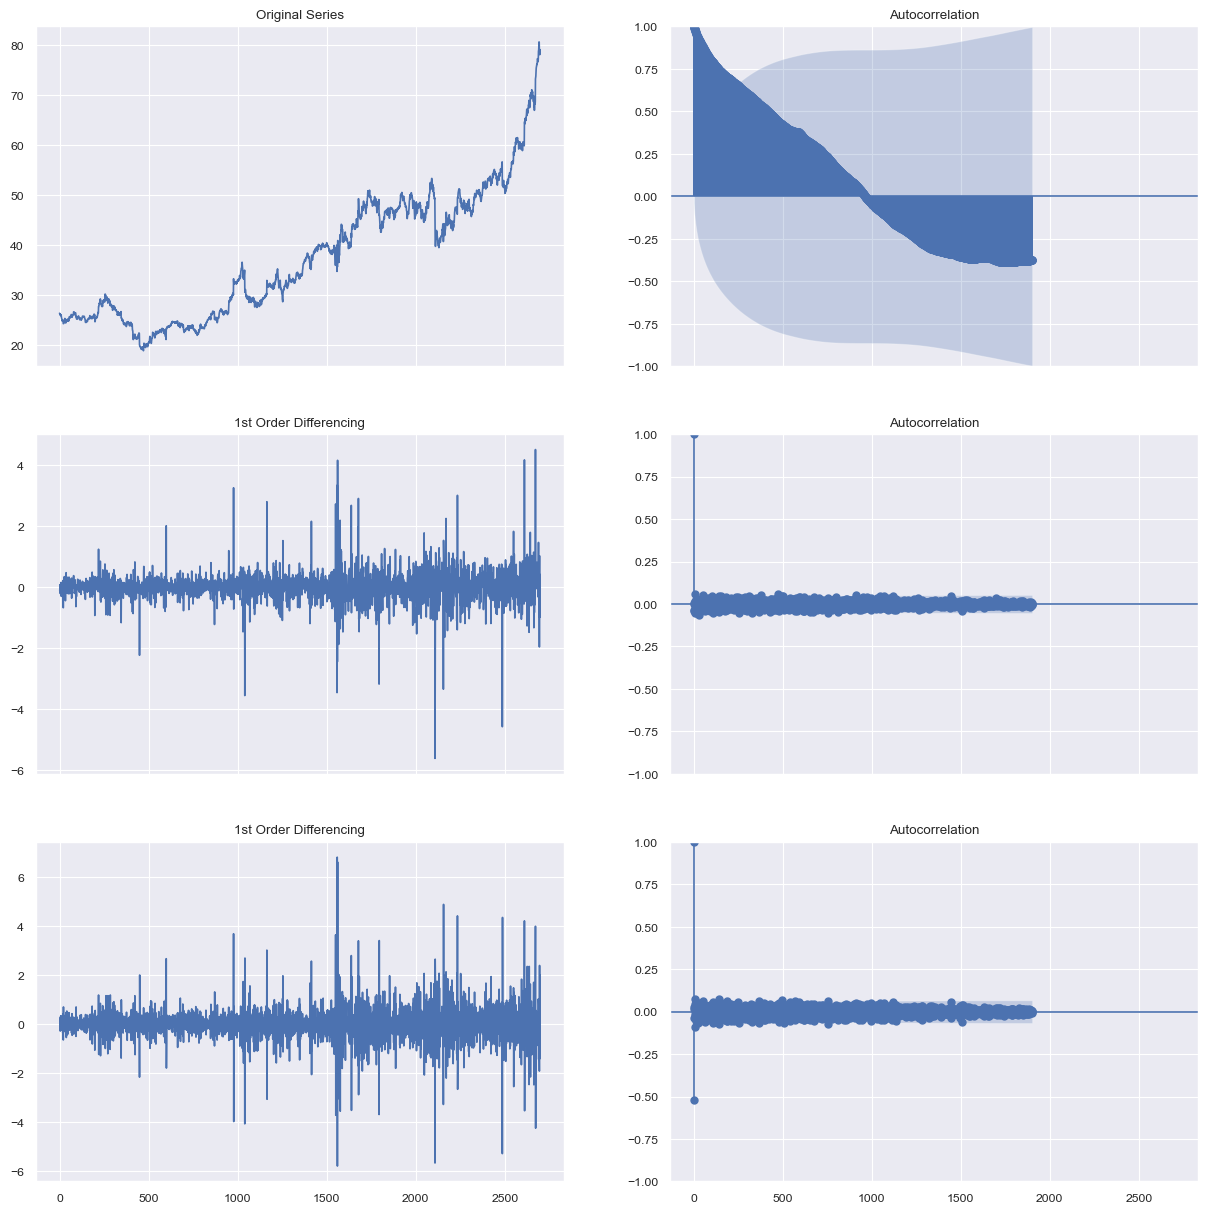

In [191]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(walmartacc_df.close); axes[0, 0].set_title('Original Series')
plot_acf(walmartacc_df.close, ax=axes[0, 1], lags = 1900);

axes[1, 0].plot(walmartacc_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(walmartacc_df.close.diff().dropna(), ax=axes[1, 1], lags = 1900);

axes[2, 0].plot(walmartacc_df.close.diff().diff()); axes[2, 0].set_title('1st Order Differencing')
plot_acf(walmartacc_df.close.diff().diff().dropna(), ax=axes[2, 1], lags = 1900);

En la gráfica anterior se muestra la serie original junto con los gráficos de autocorrelación, que nos ayudan a determinar si la serie es estacionaria. También se incluyen los gráficos de diferenciación, que indican cuántas diferencias son necesarias para hacer la serie estacionaria.

## **Estacionariedad**


Para determinar si la serie es estacionaria, aplicaremos el test de Dickey-Fuller, el cual plantea las siguientes hipótesis, si $p-value > 0.05$ no rechazamos nuestra hipotesis inicial:

$H_0$ : La serie es **NO** estacionaria

$H_1$ : La serie es estacionaria

In [192]:
result = adfuller(walmartacc_df.close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.713123
p-value: 0.998160


el p-value es mayor al nivel de significancia del 0.05, por lo tanto, no rechazamos la hipótesis nula, es decir, la serie es NO estacionaria y procederemos a usar el modelo arima.

# **AIC**

Realizamos los procedimientos para el primer criterio. con los mejores parámetros obtenidos (2,1,2).

In [193]:
pmodel = ARIMA(walmartacc_df['adjclose'].tolist(), order=(2, 1, 2)).fit()

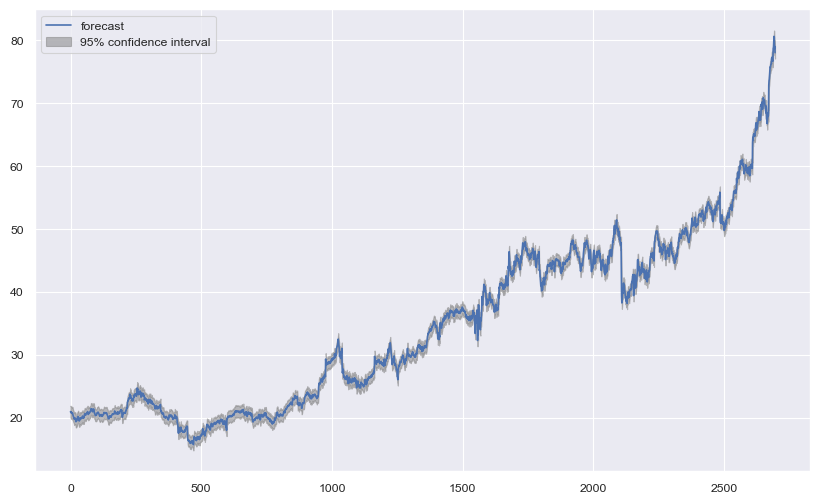

In [194]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(pmodel, 2, ax=ax);
plt.show();

Podemos observar que la linea azul que muestra la predicción según los valores del pasado se encuentra dentro del área sombreada, lo que puede significar que valores del futuro probablemente caeran dentro de esta región con un 95% de confianza.

### **Residuos**

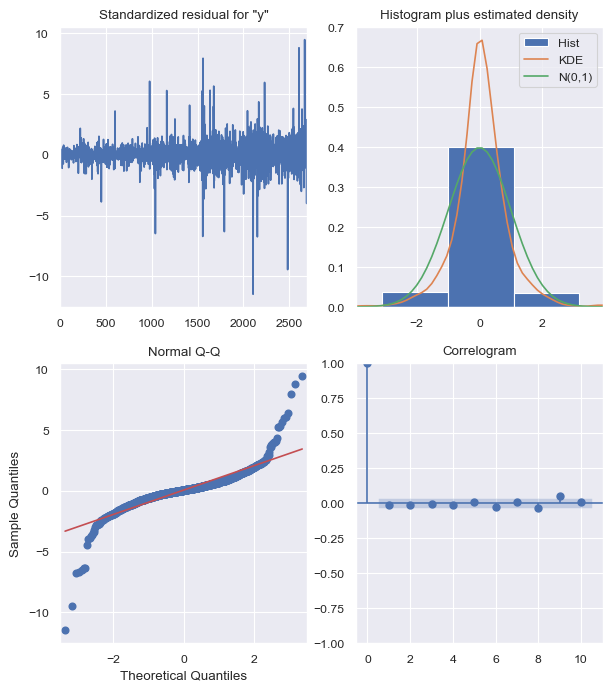

In [196]:
arima_obj_fit.plot_diagnostics(figsize=(7,8))
plt.show()

En cuanto a los residuos, despues de analizarlos visualmente, podemos decir que se distribuyen normal, además, no son dependientes entre ellos ya que no presentan correlación.

## **modelo ARIMA con aic (7 días)**

Realizamos el modelo para predecir los ultimos 7 días

In [197]:
n_walmart = len(walmartacc_df.close); n_test_7 = 7
train_size_7 = n_walmart - n_test_7
train_7 = walmartacc_df.close[:train_size_7]
dates_train_7 = walmartacc_df.date[:train_size_7]
test_7 = walmartacc_df.close[train_size_7:train_size_7 + n_test_7] 
dates_7 = walmartacc_df.date[train_size_7:train_size_7 + n_test_7] 
print("train:", train_7.shape)
print("test_4w:", test_7.shape)

train: (2691,)
test_4w: (7,)


### **rolling forecast**

Realizaremos el modelo utilizando rolling y otro sin utilizarlo.

In [198]:
def arima_rolling(history, test, best_order):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [252]:
newtest7 = test_7.tolist()
predict7  = arima_rolling(train_7.tolist(), newtest7, best_order_aic)

predicted=78.794335, expected=79.660004
predicted=79.705585, expected=80.599998
predicted=80.622663, expected=80.559998
predicted=80.518277, expected=78.599998
predicted=78.632140, expected=79.029999
predicted=79.048400, expected=78.040001
predicted=77.964630, expected=79.059998


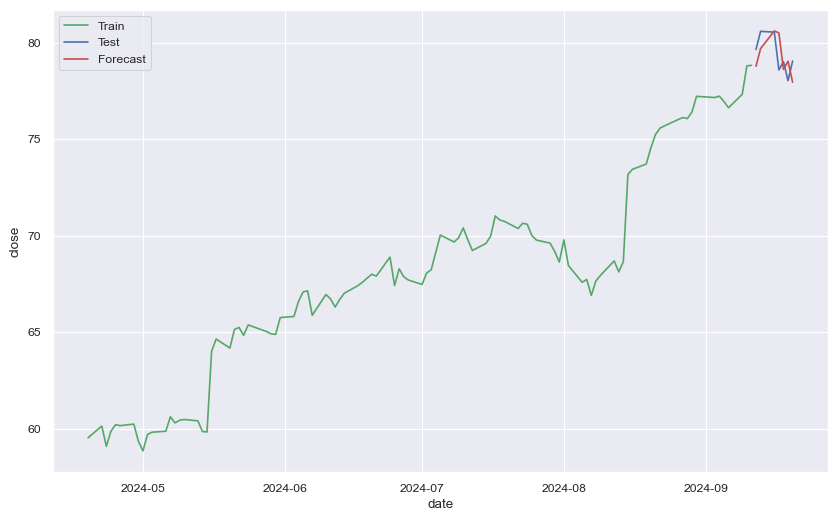

In [200]:
ax = sns.lineplot(x=dates_train_7[-100:], y=train_7[-100:], label="Train", color='g')
sns.lineplot(x=dates_7, y=newtest7, label="Test", color='b')
sns.lineplot(x=dates_7, y=predict7, label="Forecast", color='r')
plt.show()

### **Sin rolling forecast**

In [201]:
norolling7 = pmodel.forecast(steps=len(test_7))

In [202]:
for i in range(len(list(test_7))):
    obs = test_7.iloc[i] # Valores observados
    predict7 = norolling7[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs}, prediciones: {predict7}')

observaciones: 79.66000366210938, prediciones: 79.03278040738911
observaciones: 80.5999984741211, prediciones: 79.0585561746665
observaciones: 80.55999755859375, prediciones: 79.07469912026187
observaciones: 78.5999984741211, prediciones: 79.04556973851643
observaciones: 79.02999877929688, prediciones: 79.04071926936365
observaciones: 78.04000091552734, prediciones: 79.06906751019073
observaciones: 79.05999755859375, prediciones: 79.0638367210078


<Axes: xlabel='date', ylabel='close'>

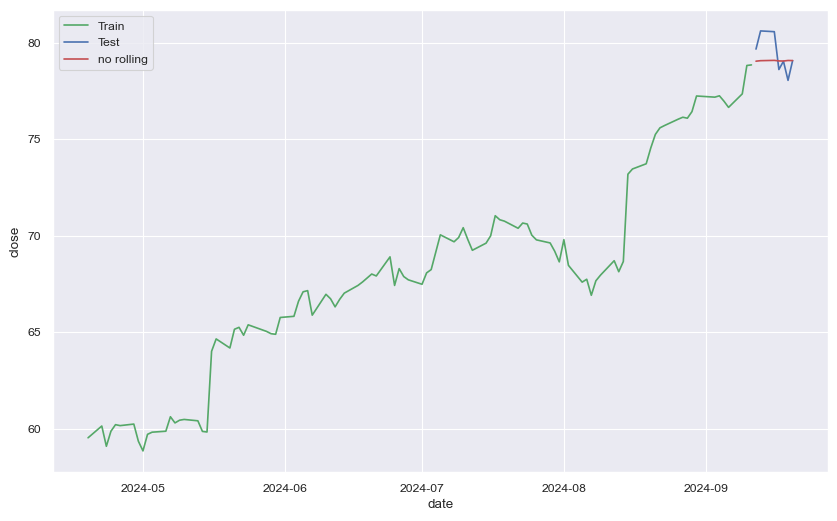

In [203]:
ax = sns.lineplot(x=dates_train_7[-100:], y=train_7[-100:], label="Train", color='g')
sns.lineplot(x=dates_7, y=test_7, label="Test", color='b')
sns.lineplot(x=dates_7, y=norolling7, label="no rolling", color='r')

Podemos observar, que cuando se aplico el modelo con rolling los valores de la predicción ajustan de una manera similar, pero, en cuanto a la parte en donde no se utilizó rolling, no ajusto de la mejor manera, dando como resultado una linea casi recta.

## **Modelo ARIMA con aic (14 días)**

Realizamos el modelo para predecir los ultimos 14 días

In [204]:
n_walmart = len(walmartacc_df.close); n_test_14 = 14 # This can be changed
train_size_14 = n_walmart - n_test_14
train_14 = walmartacc_df.close[:train_size_14]
dates_train_14 = walmartacc_df.date[:train_size_14]
test_14 = walmartacc_df.close[train_size_14:train_size_14 + n_test_14] 
dates_14 = walmartacc_df.date[train_size_14:train_size_14 + n_test_14] 
print("train:", train_14.shape)
print("test_4w:", test_14.shape)

train: (2684,)
test_4w: (14,)


### **Con rolling forecast**

In [254]:
newtest14 = test_14.tolist()
predict14  = arima_rolling(train_14.tolist(), newtest14, best_order_aic)


predicted=77.128313, expected=77.169998
predicted=77.283739, expected=77.239998
predicted=77.295536, expected=76.959999
predicted=76.845959, expected=76.639999
predicted=76.631842, expected=77.339996
predicted=77.305975, expected=78.809998
predicted=78.847028, expected=78.839996
predicted=78.794335, expected=79.660004
predicted=79.705585, expected=80.599998
predicted=80.622663, expected=80.559998
predicted=80.518277, expected=78.599998
predicted=78.632140, expected=79.029999
predicted=79.048400, expected=78.040001
predicted=77.964630, expected=79.059998


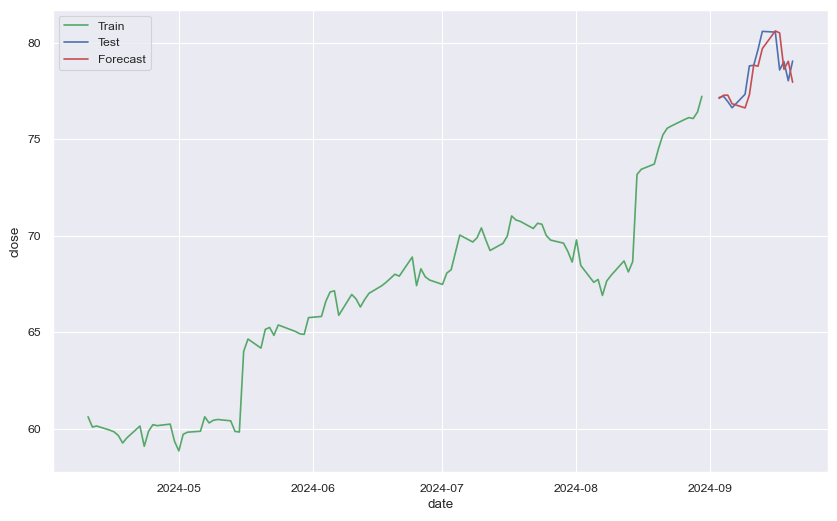

In [206]:
ax = sns.lineplot(x=dates_train_14[-100:], y=train_14[-100:], label="Train", color='g')
sns.lineplot(x=dates_14, y=newtest14 , label="Test", color='b')
sns.lineplot(x=dates_14, y=predict14, label="Forecast", color='r')
plt.show()

### **sin rolling forecast**

In [207]:
norolling14 = pmodel.forecast(steps=len(test_14))

In [208]:
for i in range(len(list(test_14))):
    obs14 = test_14.iloc[i] # Valores observados
    predict14 = norolling14[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs14}, prediciones: {predict14}')

observaciones: 77.16999816894531, prediciones: 79.03278040738911
observaciones: 77.23999786376953, prediciones: 79.0585561746665
observaciones: 76.95999908447266, prediciones: 79.07469912026187
observaciones: 76.63999938964844, prediciones: 79.04556973851643
observaciones: 77.33999633789062, prediciones: 79.04071926936365
observaciones: 78.80999755859375, prediciones: 79.06906751019073
observaciones: 78.83999633789062, prediciones: 79.0638367210078
observaciones: 79.66000366210938, prediciones: 79.03964510713615
observaciones: 80.5999984741211, prediciones: 79.05269516905315
observaciones: 80.55999755859375, prediciones: 79.07040906374458
observaciones: 78.5999984741211, prediciones: 79.05240471177271
observaciones: 79.02999877929688, prediciones: 79.0423176253941
observaciones: 78.04000091552734, prediciones: 79.06225874356238
observaciones: 79.05999755859375, prediciones: 79.06469596211976


<Axes: xlabel='date', ylabel='close'>

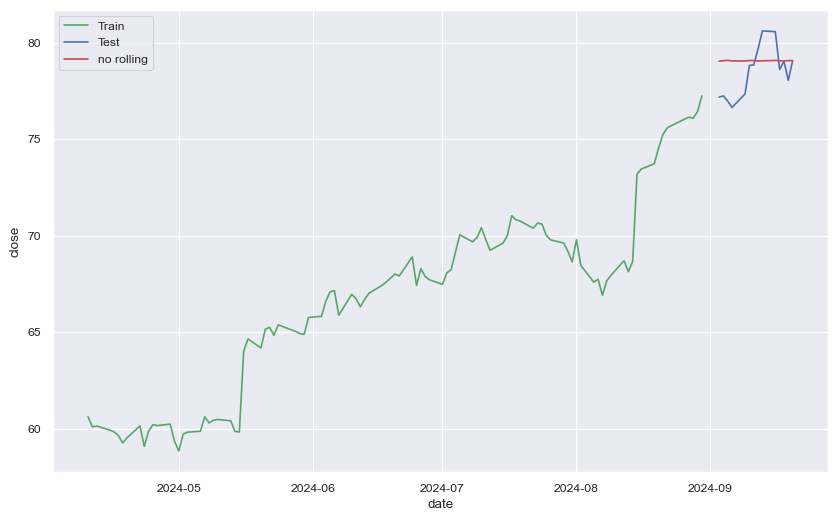

In [209]:
ax = sns.lineplot(x=dates_train_14[-100:], y=train_14[-100:], label="Train", color='g')
sns.lineplot(x=dates_14, y=test_14, label="Test", color='b')
sns.lineplot(x=dates_14, y=norolling14, label="no rolling", color='r')

Podemos observar que cuando se hace uso del rolling el modelo ajusta de una buena manera. En cuanto al modelo sin rolling, los errores son significativos ya que siempre suele predecir valores cercanos al mismo número, dando como resultado predicciones que parecen ser una linea.

## **Modelo ARIMA con aic (21 días)**

Realizamos el modelo para predecir los ultimos 21 días

In [210]:
n_walmart = len(walmartacc_df.close); n_test_21 = 21 # This can be changed
train_size_21 = n_walmart - n_test_21
train_21 = walmartacc_df.close[:train_size_21]
dates_train_21 = walmartacc_df.date[:train_size_21]
test_21 = walmartacc_df.close[train_size_21:train_size_21 + n_test_21] 
dates_21 = walmartacc_df.date[train_size_21:train_size_21 + n_test_21] 
print("train:", train_21.shape)
print("test_4w:", test_21.shape)

train: (2677,)
test_4w: (21,)


### **Con rolling forecast**

In [256]:
newtest21 = test_21.tolist()
predict21  = arima_rolling(train_21.tolist(), newtest21, best_order_aic)

predicted=75.183895, expected=75.580002
predicted=75.727214, expected=75.699997
predicted=75.702937, expected=76.029999
predicted=75.886918, expected=76.129997
predicted=76.171079, expected=76.080002
predicted=76.199872, expected=76.419998
predicted=76.336309, expected=77.230003
predicted=77.128313, expected=77.169998
predicted=77.283739, expected=77.239998
predicted=77.295536, expected=76.959999
predicted=76.845959, expected=76.639999
predicted=76.631842, expected=77.339996
predicted=77.305975, expected=78.809998
predicted=78.847028, expected=78.839996
predicted=78.794335, expected=79.660004
predicted=79.705585, expected=80.599998
predicted=80.622663, expected=80.559998
predicted=80.518277, expected=78.599998
predicted=78.632140, expected=79.029999
predicted=79.048400, expected=78.040001
predicted=77.964630, expected=79.059998


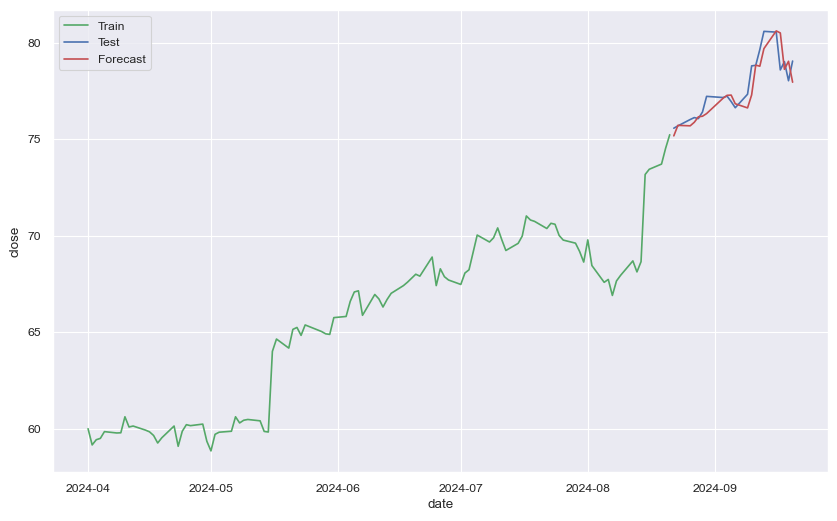

In [212]:
ax = sns.lineplot(x=dates_train_21[-100:], y=train_21[-100:], label="Train", color='g')
sns.lineplot(x=dates_21, y=newtest21 , label="Test", color='b')
sns.lineplot(x=dates_21[:len(predict21)], y=predict21, label="Forecast", color='r')
plt.show()

### **Sin rolling forecast**

In [213]:
norolling21 = pmodel.forecast(steps=len(test_21))

In [214]:
for i in range(len(list(test_21))):
    obs21 = test_21.iloc[i] # Valores observados
    predict21 = norolling21[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs21}, prediciones: {predict21}')

observaciones: 75.58000183105469, prediciones: 79.03278040738911
observaciones: 75.69999694824219, prediciones: 79.0585561746665
observaciones: 76.02999877929688, prediciones: 79.07469912026187
observaciones: 76.12999725341797, prediciones: 79.04556973851643
observaciones: 76.08000183105469, prediciones: 79.04071926936365
observaciones: 76.41999816894531, prediciones: 79.06906751019073
observaciones: 77.2300033569336, prediciones: 79.0638367210078
observaciones: 77.16999816894531, prediciones: 79.03964510713615
observaciones: 77.23999786376953, prediciones: 79.05269516905315
observaciones: 76.95999908447266, prediciones: 79.07040906374458
observaciones: 76.63999938964844, prediciones: 79.05240471177271
observaciones: 77.33999633789062, prediciones: 79.0423176253941
observaciones: 78.80999755859375, prediciones: 79.06225874356238
observaciones: 78.83999633789062, prediciones: 79.06469596211976
observaciones: 79.66000366210938, prediciones: 79.04559105837626
observaciones: 80.59999847412

<Axes: xlabel='date', ylabel='close'>

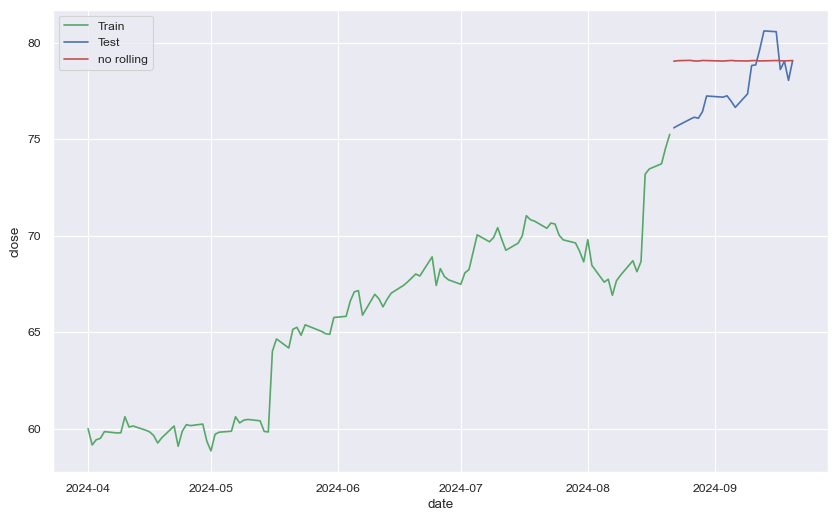

In [215]:
ax = sns.lineplot(x=dates_train_21[-100:], y=train_21[-100:], label="Train", color='g')
sns.lineplot(x=dates_21, y=test_21, label="Test", color='b')
sns.lineplot(x=dates_21, y=norolling21, label="no rolling", color='r')

Al igual que en los casos anteriores, las predicciones en donde se hace uso del rolling ajustan y predicen de una buena manera, pero cuando se aplica la tecnica sin rolling el error es bastante grande, dando como resultado valores similares siempre, lo que da como resultado en la grafica una linea casi recta.

## **Modelo ARIMA con aic (28 días)**

Realizamos el modelo para predecir los ultimos 28 días

In [216]:
n_walmart = len(walmartacc_df.close); n_test_28 = 28 # This can be changed
train_size_28 = n_walmart - n_test_28
train_28 = walmartacc_df.close[:train_size_28]
dates_train_28 = walmartacc_df.date[:train_size_28]
test_28 = walmartacc_df.close[train_size_28:train_size_28 + n_test_28] 
dates_28 = walmartacc_df.date[train_size_28:train_size_28 + n_test_28] 
print("train:", train_28.shape)
print("test_4w:", test_28.shape)

train: (2670,)
test_4w: (28,)


### **Con rolling forecast**

In [259]:
newtest28 = test_28.tolist()
predict28  = arima_rolling(train_28.tolist(), newtest28, best_order_aic)

predicted=68.663000, expected=68.129997
predicted=68.149877, expected=68.660004
predicted=68.629489, expected=73.180000
predicted=72.987602, expected=73.449997
predicted=73.553117, expected=73.720001
predicted=73.647573, expected=74.540001
predicted=74.389603, expected=75.239998
predicted=75.183895, expected=75.580002
predicted=75.727214, expected=75.699997
predicted=75.702937, expected=76.029999
predicted=75.886918, expected=76.129997
predicted=76.171079, expected=76.080002
predicted=76.199872, expected=76.419998
predicted=76.336309, expected=77.230003
predicted=77.128313, expected=77.169998
predicted=77.283739, expected=77.239998
predicted=77.295536, expected=76.959999
predicted=76.845959, expected=76.639999
predicted=76.631842, expected=77.339996
predicted=77.305975, expected=78.809998
predicted=78.847028, expected=78.839996
predicted=78.794335, expected=79.660004
predicted=79.705585, expected=80.599998
predicted=80.622663, expected=80.559998
predicted=80.518277, expected=78.599998


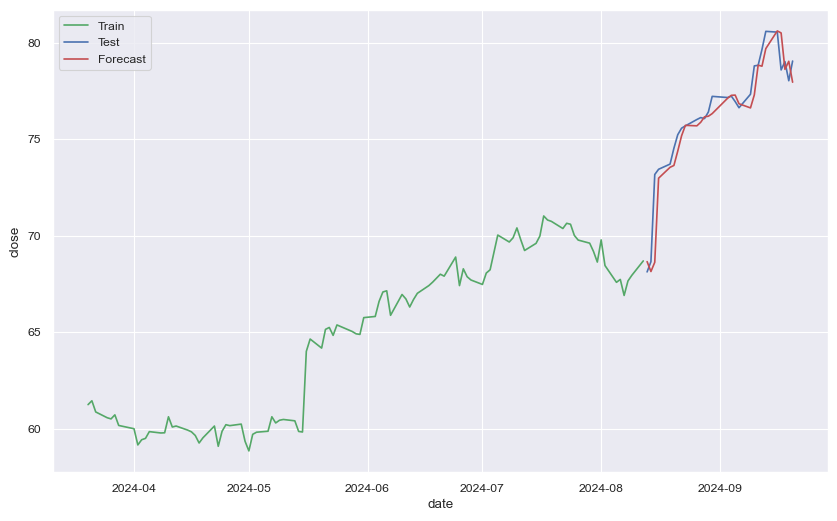

In [218]:
ax = sns.lineplot(x=dates_train_28[-100:], y=train_28[-100:], label="Train", color='g')
sns.lineplot(x=dates_28, y=newtest28 , label="Test", color='b')
sns.lineplot(x=dates_28[:len(predict28)], y=predict28, label="Forecast", color='r')
plt.show()

### **Sin rolling forecast**

In [219]:
norolling28 = pmodel.forecast(steps=len(test_28))

In [220]:
for i in range(len(list(test_28))):
    obs28 = test_28.iloc[i] # Valores observados
    predict28 = norolling28[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs28}, prediciones: {predict28}')

observaciones: 68.12999725341797, prediciones: 79.03278040738911
observaciones: 68.66000366210938, prediciones: 79.0585561746665
observaciones: 73.18000030517578, prediciones: 79.07469912026187
observaciones: 73.44999694824219, prediciones: 79.04556973851643
observaciones: 73.72000122070312, prediciones: 79.04071926936365
observaciones: 74.54000091552734, prediciones: 79.06906751019073
observaciones: 75.23999786376953, prediciones: 79.0638367210078
observaciones: 75.58000183105469, prediciones: 79.03964510713615
observaciones: 75.69999694824219, prediciones: 79.05269516905315
observaciones: 76.02999877929688, prediciones: 79.07040906374458
observaciones: 76.12999725341797, prediciones: 79.05240471177271
observaciones: 76.08000183105469, prediciones: 79.0423176253941
observaciones: 76.41999816894531, prediciones: 79.06225874356238
observaciones: 77.2300033569336, prediciones: 79.06469596211976
observaciones: 77.16999816894531, prediciones: 79.04559105837626
observaciones: 77.23999786376

<Axes: xlabel='date', ylabel='close'>

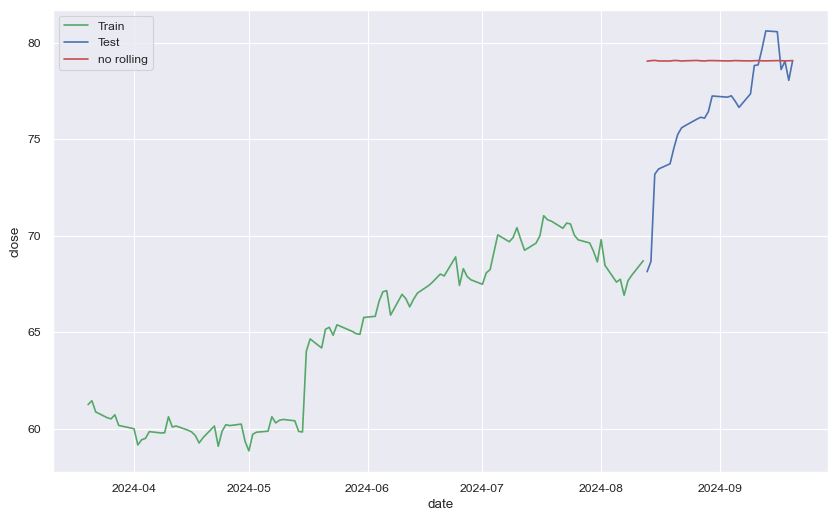

In [221]:
ax = sns.lineplot(x=dates_train_28[-100:], y=train_28[-100:], label="Train", color='g')
sns.lineplot(x=dates_28, y=test_28, label="Test", color='b')
sns.lineplot(x=dates_28, y=norolling28, label="no rolling", color='r')

En esta ocasión podemos ver notablemente el error de la tecnica cuando no se aplica el rolling, ya que no predice los valores de la mejor manera, dando como resultado una linea casi recta, en cambio, cuando se usa rolling los valores predecidos y los del test son bastante similares.

# **BIC**

Realizamos los procedimientos para el segundo criterio, con los mejores parámetros obtenidos (1,1,1)

In [222]:
smodel = ARIMA(walmartacc_df['adjclose'].tolist(), order=(1, 1, 1)).fit()

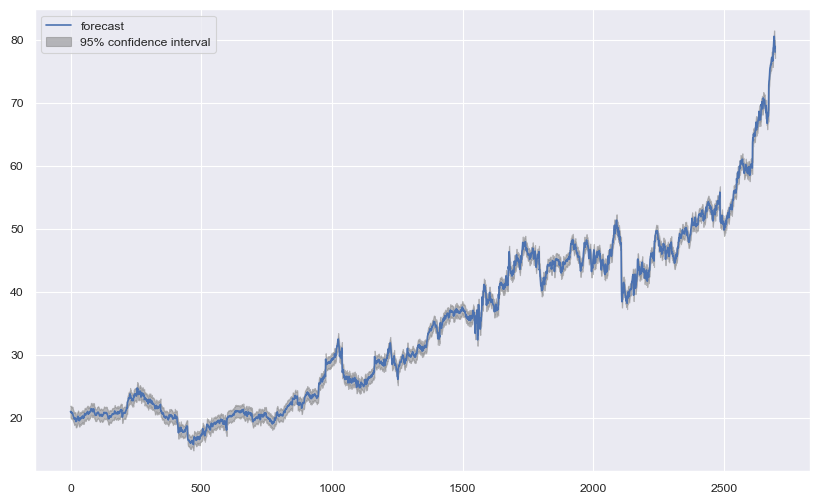

In [223]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(smodel, 2, ax=ax);
plt.show();

En esta ocasión podemos observar que la linea en azul se encuentra dentro del área sombrada, lo que significa que los valores futuros pueden caer dentro de esta área con un 95% de confianza, además, se observa una tendencia ascendente.

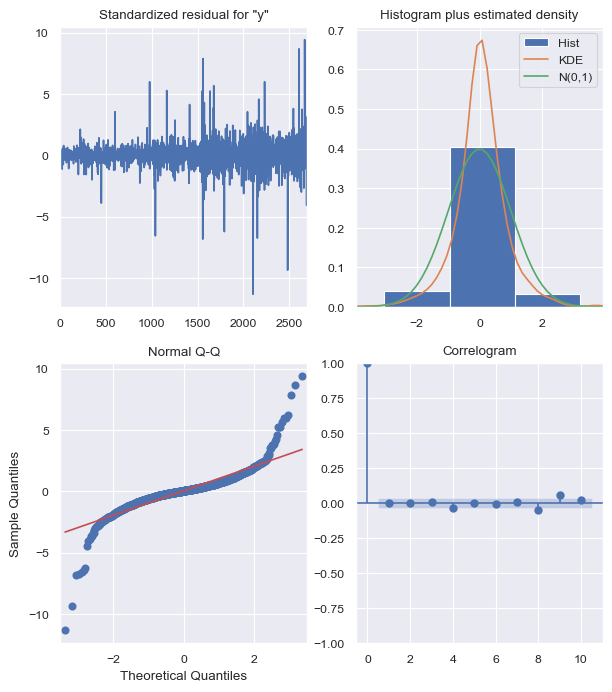

In [225]:
arima_obj_fit.plot_diagnostics(figsize=(7,8))
plt.show()

Luego de realizar la gráfica anterior, podemos decir que los residuos se distribuyen normalmente y no tienen dependencia entre ellos, ya que no presentan ninguna correlación.

## **Modelo ARIMA con bic (7 días)**

Realizamos el modelo para predecir los ultimos 7 días

### **Con rolling forecast**

In [269]:
newtest7_bic = test_7.tolist()
predict7_bic  = arima_rolling(train_7.tolist(), newtest7_bic, best_order_bic)

predicted=78.894793, expected=79.660004
predicted=79.686134, expected=80.599998
predicted=80.628519, expected=80.559998
predicted=80.628930, expected=78.599998
predicted=78.733744, expected=79.029999
predicted=79.067121, expected=78.040001
predicted=78.131486, expected=79.059998


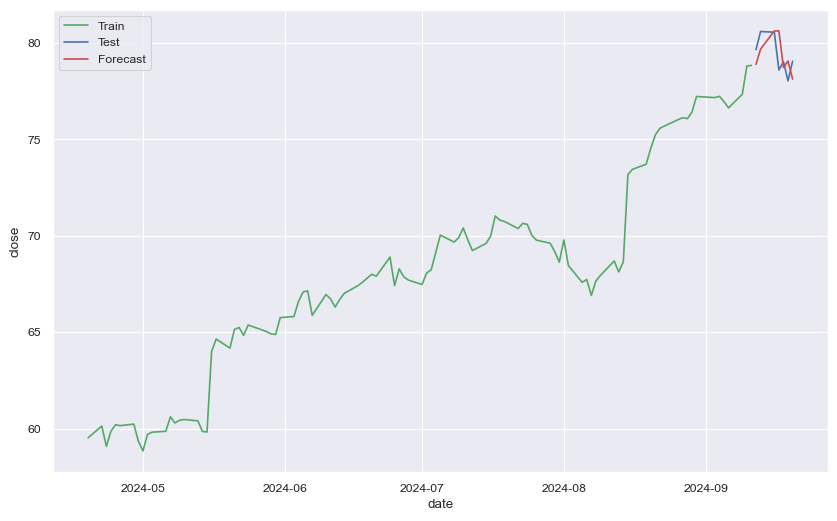

In [227]:
ax = sns.lineplot(x=dates_train_7[-100:], y=train_7[-100:], label="Train", color='g')
sns.lineplot(x=dates_7, y=newtest7_bic, label="Test", color='b')
sns.lineplot(x=dates_7, y=predict7_bic, label="Forecast", color='r')
plt.show()

### **Sin rolling forecast**

In [275]:
norolling7_bic = smodel.forecast(steps=len(test_7))

In [229]:
for i in range(len(list(test_7))):
    obs_aic = test_7.iloc[i] # Valores observados
    predict7_aic = norolling7_bic[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs_aic}, prediciones: {predict7_aic}')

observaciones: 79.66000366210938, prediciones: 79.02063718943211
observaciones: 80.5999984741211, prediciones: 79.02349555504853
observaciones: 80.55999755859375, prediciones: 79.02328797940402
observaciones: 78.5999984741211, prediciones: 79.02330305362963
observaciones: 79.02999877929688, prediciones: 79.02330195893339
observaciones: 78.04000091552734, prediciones: 79.02330203843066
observaciones: 79.05999755859375, prediciones: 79.02330203265754


<Axes: xlabel='date', ylabel='close'>

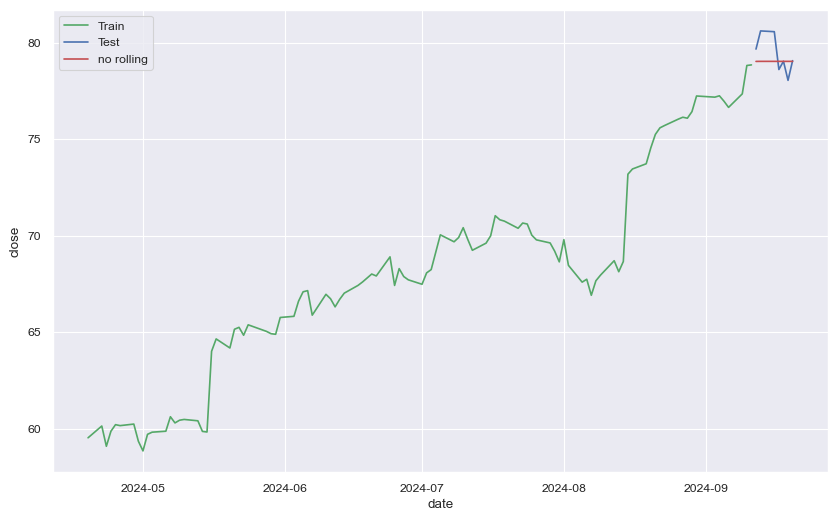

In [230]:
ax = sns.lineplot(x=dates_train_7[-100:], y=train_7[-100:], label="Train", color='g')
sns.lineplot(x=dates_7, y=test_7, label="Test", color='b')
sns.lineplot(x=dates_7, y=norolling7_bic, label="no rolling", color='r')

## **Modelo ARIMA con bic (14 días)**

Realizamos el modelo para predecir los ultimos 14 días

### **Con rolling forecast**

In [270]:
newtest14_bic = test_14.tolist()
predict14_bic  = arima_rolling(train_14.tolist(), newtest14_bic, best_order_bic)

predicted=77.243612, expected=77.169998
predicted=77.221056, expected=77.239998
predicted=77.285451, expected=76.959999
predicted=77.019086, expected=76.639999
predicted=76.699587, expected=77.339996
predicted=77.357531, expected=78.809998
predicted=78.803334, expected=78.839996
predicted=78.894793, expected=79.660004
predicted=79.686134, expected=80.599998
predicted=80.628519, expected=80.559998
predicted=80.628930, expected=78.599998
predicted=78.733744, expected=79.029999
predicted=79.067121, expected=78.040001
predicted=78.131486, expected=79.059998


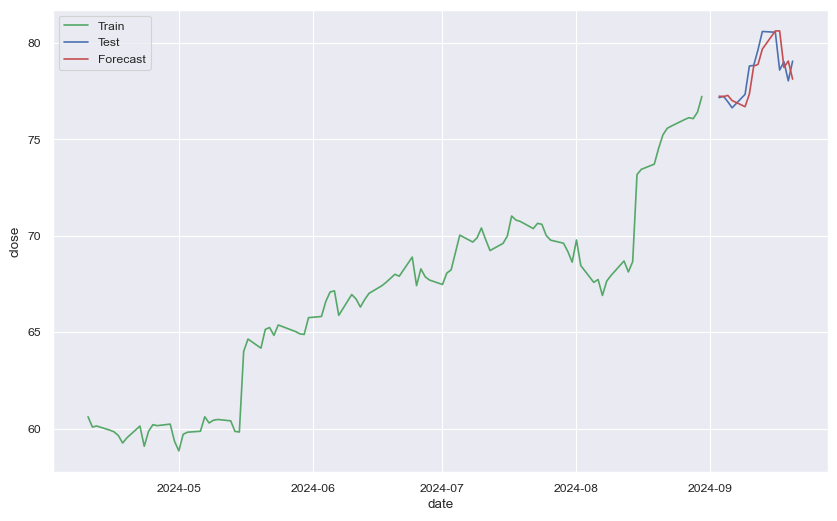

In [232]:
ax = sns.lineplot(x=dates_train_14[-100:], y=train_14[-100:], label="Train", color='g')
sns.lineplot(x=dates_14, y=newtest14_bic , label="Test", color='b')
sns.lineplot(x=dates_14, y=predict14_bic, label="Forecast", color='r')
plt.show()

### **Sin rolling forecast**

In [233]:
norolling14_bic = smodel.forecast(steps=len(test_14))

In [234]:
for i in range(len(list(test_14))):
    obs14_bic = test_14.iloc[i] # Valores observados
    predict14_bic = norolling14_bic[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs14_bic}, prediciones: {predict14_bic}')

observaciones: 77.16999816894531, prediciones: 79.02063718943211
observaciones: 77.23999786376953, prediciones: 79.02349555504853
observaciones: 76.95999908447266, prediciones: 79.02328797940402
observaciones: 76.63999938964844, prediciones: 79.02330305362963
observaciones: 77.33999633789062, prediciones: 79.02330195893339
observaciones: 78.80999755859375, prediciones: 79.02330203843066
observaciones: 78.83999633789062, prediciones: 79.02330203265754
observaciones: 79.66000366210938, prediciones: 79.02330203307679
observaciones: 80.5999984741211, prediciones: 79.02330203304635
observaciones: 80.55999755859375, prediciones: 79.02330203304857
observaciones: 78.5999984741211, prediciones: 79.02330203304841
observaciones: 79.02999877929688, prediciones: 79.02330203304842
observaciones: 78.04000091552734, prediciones: 79.02330203304842
observaciones: 79.05999755859375, prediciones: 79.02330203304842


<Axes: xlabel='date', ylabel='close'>

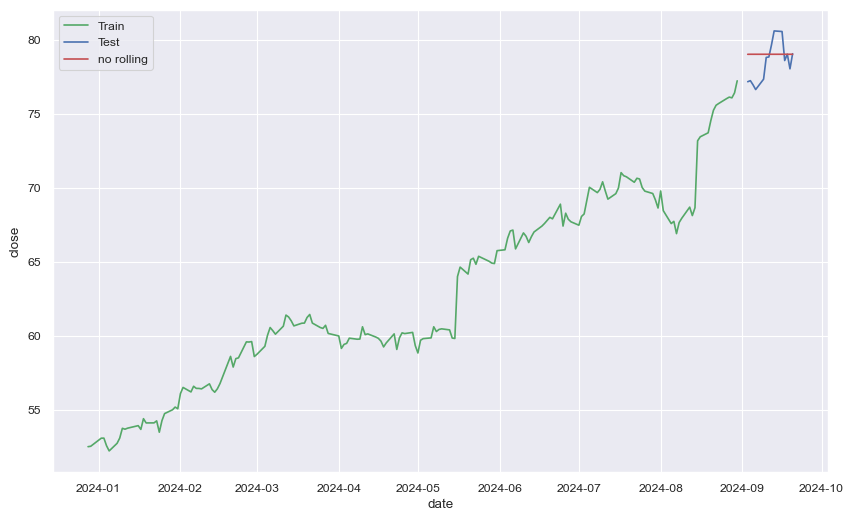

In [235]:
ax = sns.lineplot(x=dates_train_14[-170:], y=train_14[-170:], label="Train", color='g')
sns.lineplot(x=dates_14, y=test_14, label="Test", color='b')
sns.lineplot(x=dates_14, y=norolling14_bic, label="no rolling", color='r')

## **Modelo ARIMA con bic (21 días)**

Realizamos el modelo para predecir los ultimos 21 días

### **Con rolling forecast**

In [271]:
newtest21_bic = test_21.tolist()
predict21_bic  = arima_rolling(train_21.tolist(), newtest21_bic, best_order_bic)

predicted=75.250106, expected=75.580002
predicted=75.607345, expected=75.699997
predicted=75.737393, expected=76.029999
predicted=76.059474, expected=76.129997
predicted=76.169749, expected=76.080002
predicted=76.125941, expected=76.419998
predicted=76.450209, expected=77.230003
predicted=77.243612, expected=77.169998
predicted=77.221056, expected=77.239998
predicted=77.285451, expected=76.959999
predicted=77.019086, expected=76.639999
predicted=76.699587, expected=77.339996
predicted=77.357531, expected=78.809998
predicted=78.803334, expected=78.839996
predicted=78.894793, expected=79.660004
predicted=79.686134, expected=80.599998
predicted=80.628519, expected=80.559998
predicted=80.628930, expected=78.599998
predicted=78.733744, expected=79.029999
predicted=79.067121, expected=78.040001
predicted=78.131486, expected=79.059998


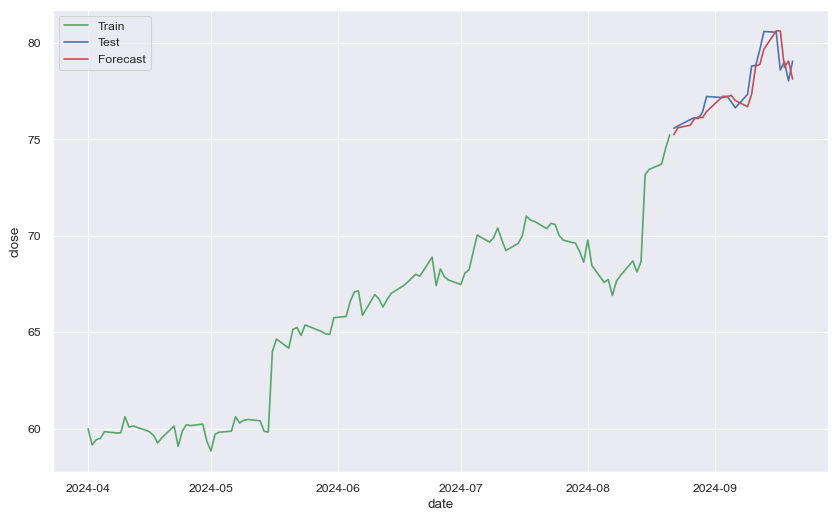

In [239]:
ax = sns.lineplot(x=dates_train_21[-100:], y=train_21[-100:], label="Train", color='g')
sns.lineplot(x=dates_21, y=newtest21_bic, label="Test", color='b')
sns.lineplot(x=dates_21, y=predict21_bic, label="Forecast", color='r')
plt.show()

### **Sin rolling forecast**

In [240]:
norolling21_bic = smodel.forecast(steps=len(test_21))

In [241]:
for i in range(len(list(test_21))):
    obs21_bic = test_21.iloc[i] # Valores observados
    predict21_bic = norolling21_bic[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs21_bic}, prediciones: {predict21_bic}')

observaciones: 75.58000183105469, prediciones: 79.02063718943211
observaciones: 75.69999694824219, prediciones: 79.02349555504853
observaciones: 76.02999877929688, prediciones: 79.02328797940402
observaciones: 76.12999725341797, prediciones: 79.02330305362963
observaciones: 76.08000183105469, prediciones: 79.02330195893339
observaciones: 76.41999816894531, prediciones: 79.02330203843066
observaciones: 77.2300033569336, prediciones: 79.02330203265754
observaciones: 77.16999816894531, prediciones: 79.02330203307679
observaciones: 77.23999786376953, prediciones: 79.02330203304635
observaciones: 76.95999908447266, prediciones: 79.02330203304857
observaciones: 76.63999938964844, prediciones: 79.02330203304841
observaciones: 77.33999633789062, prediciones: 79.02330203304842
observaciones: 78.80999755859375, prediciones: 79.02330203304842
observaciones: 78.83999633789062, prediciones: 79.02330203304842
observaciones: 79.66000366210938, prediciones: 79.02330203304842
observaciones: 80.59999847

<Axes: xlabel='date', ylabel='close'>

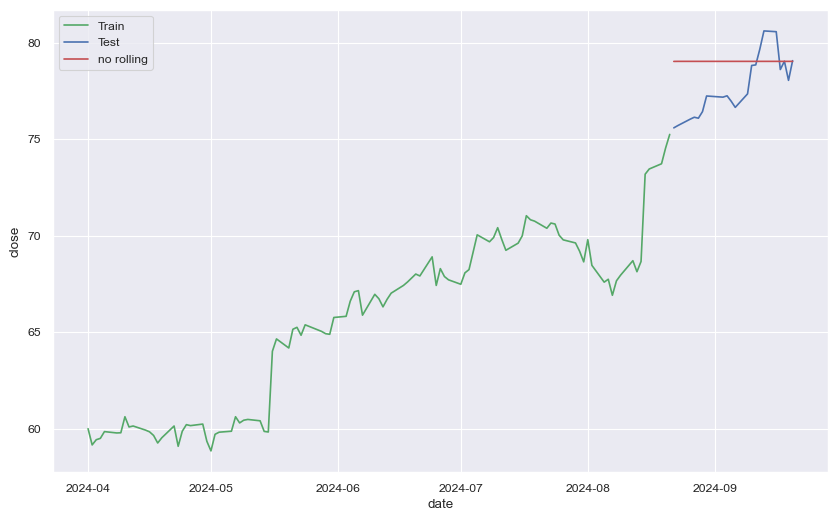

In [242]:
ax = sns.lineplot(x=dates_train_21[-100:], y=train_21[-100:], label="Train", color='g')
sns.lineplot(x=dates_21, y=test_21, label="Test", color='b')
sns.lineplot(x=dates_21, y=norolling21_bic, label="no rolling", color='r')

## **Modelo ARIMA con bic (28 días)**

Realizamos el modelo para predecir los ultimos 28 días

### **Con rolling forecast**

In [272]:
newtest28_bic = test_28.tolist()
predict28_bic  = arima_rolling(train_28.tolist(), newtest28_bic, best_order_bic)

predicted=68.685911, expected=68.129997
predicted=68.179935, expected=68.660004
predicted=68.654990, expected=73.180000
predicted=72.996775, expected=73.449997
predicted=73.472463, expected=73.720001
predicted=73.743305, expected=74.540001
predicted=74.541554, expected=75.239998
predicted=75.250106, expected=75.580002
predicted=75.607345, expected=75.699997
predicted=75.737393, expected=76.029999
predicted=76.059474, expected=76.129997
predicted=76.169749, expected=76.080002
predicted=76.125941, expected=76.419998
predicted=76.450209, expected=77.230003
predicted=77.243612, expected=77.169998
predicted=77.221056, expected=77.239998
predicted=77.285451, expected=76.959999
predicted=77.019086, expected=76.639999
predicted=76.699587, expected=77.339996
predicted=77.357531, expected=78.809998
predicted=78.803334, expected=78.839996
predicted=78.894793, expected=79.660004
predicted=79.686134, expected=80.599998
predicted=80.628519, expected=80.559998
predicted=80.628930, expected=78.599998


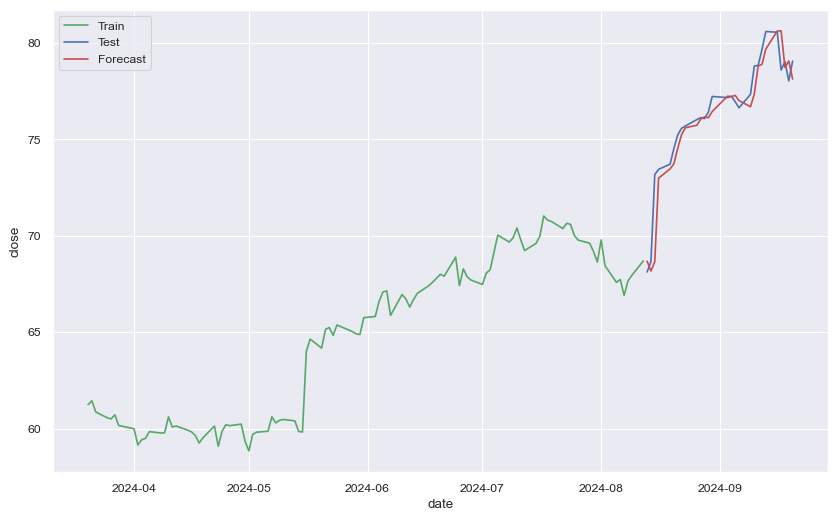

In [244]:
ax = sns.lineplot(x=dates_train_28[-100:], y=train_28[-100:], label="Train", color='g')
sns.lineplot(x=dates_28, y=newtest28_bic , label="Test", color='b')
sns.lineplot(x=dates_28, y=predict28_bic, label="Forecast", color='r')
plt.show()

### **Sin rolling forecast**

In [245]:
norolling28_bic = smodel.forecast(steps=len(test_28))

In [246]:
for i in range(len(list(test_28))):
    obs28_bic = test_28.iloc[i] # Valores observados
    predict28_bic = norolling28_bic[i]  # Predicciones ya alineadas con el test set
    print(f'observaciones: {obs28_bic}, prediciones: {predict28_bic}')

observaciones: 68.12999725341797, prediciones: 79.02063718943211
observaciones: 68.66000366210938, prediciones: 79.02349555504853
observaciones: 73.18000030517578, prediciones: 79.02328797940402
observaciones: 73.44999694824219, prediciones: 79.02330305362963
observaciones: 73.72000122070312, prediciones: 79.02330195893339
observaciones: 74.54000091552734, prediciones: 79.02330203843066
observaciones: 75.23999786376953, prediciones: 79.02330203265754
observaciones: 75.58000183105469, prediciones: 79.02330203307679
observaciones: 75.69999694824219, prediciones: 79.02330203304635
observaciones: 76.02999877929688, prediciones: 79.02330203304857
observaciones: 76.12999725341797, prediciones: 79.02330203304841
observaciones: 76.08000183105469, prediciones: 79.02330203304842
observaciones: 76.41999816894531, prediciones: 79.02330203304842
observaciones: 77.2300033569336, prediciones: 79.02330203304842
observaciones: 77.16999816894531, prediciones: 79.02330203304842
observaciones: 77.23999786

<Axes: xlabel='date', ylabel='close'>

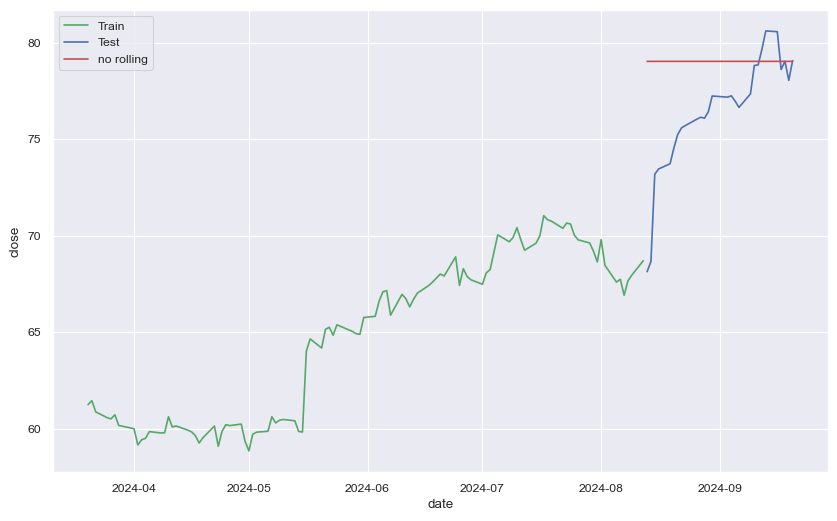

In [247]:
ax = sns.lineplot(x=dates_train_28[-100:], y=train_28[-100:], label="Train", color='g')
sns.lineplot(x=dates_28, y=test_28, label="Test", color='b')
sns.lineplot(x=dates_28, y=norolling28_bic, label="no rolling", color='r')

Tras analizar las gráficas con y sin el uso de rolling para cada uno de los días que queremos predecir, podemos concluir que las predicciones con rolling logran ajustarse mucho mejor al conjunto de prueba, proporcionando valores muy cercanos y reflejando un ajuste más preciso. En cambio, en las predicciones sin rolling, observamos que los valores tienden a mantenerse alrededor de un número constante, lo que genera grandes errores al predecir, resultando en líneas casi rectas debido a la falta de ajuste.

# **HQIC**

En esta ocasión, los valores obtenidos para el criterio AIC fueron iguales, por lo que no es necesario realizar procedimientos adicionales, ya que todo se llevaría a cabo de la misma manera.

# **Metricas de errores**

### **Métricas de error usando rolling para el aic**

In [248]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [264]:
metricas7 = forecast_accuracy(np.array(newtest7), np.array(predict7), "7 días")
metricas14 = forecast_accuracy(np.array(newtest14), np.array(predict14), "14 días")
metricas21 = forecast_accuracy(np.array(newtest21), np.array(predict21), "21 días")
metricas28 = forecast_accuracy(np.array(newtest28), np.array(predict28), "28 días")


In [265]:
metricas = pd.concat([metricas7,metricas14, metricas21, metricas28])
metricas

,MAE,MSE,MAPE,RMSE,R2
7 días,0.891808,1.086867,0.011239,1.042529,-0.361900
14 días,0.649199,0.752167,0.008256,0.867276,0.511259
21 días,0.537483,0.557594,0.006882,0.746722,0.756216
28 días,0.687603,1.240079,0.009223,1.113588,0.857064


Podemos decir que el modelo que muestra un mejor desempeñi es el horizonte de 21 días, ya que tienen las métricas más bajas, además de un $R^2$ positivo y significativo.

### **Métricas de error sin usar rolling para el aic**

In [266]:
metricas7 = forecast_accuracy(np.array(newtest7), np.array(norolling7), "7 días")
metricas14 = forecast_accuracy(np.array(newtest14), np.array(norolling14), "14 días")
metricas21 = forecast_accuracy(np.array(newtest21), np.array(norolling21), "21 días")
metricas28 = forecast_accuracy(np.array(newtest28), np.array(norolling28), "28 días")

In [267]:
metricas = pd.concat([metricas7,metricas14, metricas21, metricas28])
metricas

,MAE,MSE,MAPE,RMSE,R2
7 días,0.734737,0.890458,0.009293,0.943641,-0.115789
14 días,1.109584,1.878089,0.014036,1.370434,-0.220339
21 días,1.702439,4.116307,0.021535,2.028868,-0.799678
28 días,2.936287,15.820280,0.037143,3.977472,-0.823499


De estas métricas se puede concluir que el desempeño del modelo es deficiente, en especial en horizontes de tiempo más largos, además, que el $R^2$ negativo indica que el modelo no es el adecuado.

### **Métricas de error usando rolling para el bic**

In [273]:
metricas7 = forecast_accuracy(np.array(newtest7), np.array(predict7_bic), "7 días")
metricas14 = forecast_accuracy(np.array(newtest14), np.array(predict14_bic), "14 días")
metricas21 = forecast_accuracy(np.array(newtest21), np.array(predict21_bic), "21 días")
metricas28 = forecast_accuracy(np.array(newtest28), np.array(predict28_bic), "28 días")

In [274]:
metricas = pd.concat([metricas7,metricas14, metricas21, metricas28])
metricas

,MAE,MSE,MAPE,RMSE,R2
7 días,0.861202,1.078118,0.010831,1.038325,-0.350937
14 días,0.639646,0.737383,0.008124,0.858710,0.520865
21 días,0.519253,0.534951,0.006637,0.731403,0.766116
28 días,0.666472,1.201372,0.008935,1.096071,0.861526


Este modelo, muestra un redimiento creciente, con las métricas más bajas en el horizonte de 21 días. Este modelo es más efectivo para predicciones entre 14 y 21 días.

### **Métricas de error sin usar rolling para el bic**

In [276]:
metricas7 = forecast_accuracy(np.array(newtest7), np.array(norolling7_bic), "7 días")
metricas14 = forecast_accuracy(np.array(newtest14), np.array(norolling14_bic), "14 días")
metricas21 = forecast_accuracy(np.array(newtest21), np.array(norolling21_bic), "21 días")
metricas28 = forecast_accuracy(np.array(newtest28), np.array(norolling28_bic), "28 días")

In [277]:
metricas = pd.concat([metricas7,metricas14, metricas21, metricas28])
metricas

,MAE,MSE,MAPE,RMSE,R2
7 días,0.743225,0.914727,0.009405,0.956413,-0.146199
14 días,1.097195,1.846850,0.013885,1.358988,-0.200041
21 días,1.683517,4.035041,0.021304,2.008741,-0.764148
28 días,2.914177,15.660898,0.036878,3.957385,-0.805128


Este modelo presenta un rendimiento deficiente, ya que a medida que aumentan los horizontes tambien aumentan las métricas de error, además que en todos se presentan un $R^2$ negativo.

## **Correlación entre la observación real y predicción del test en AIC**

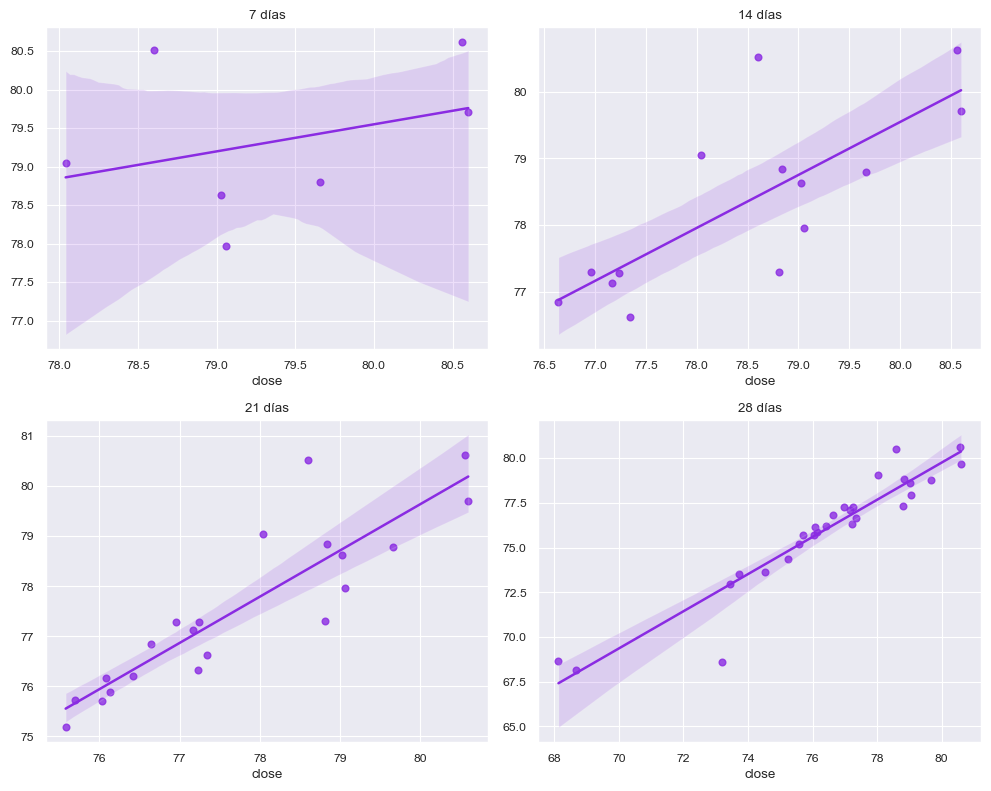

In [299]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

#(7 días)
sns.regplot(x=test_7, y=predict7, color="#8A2BE2", ax=axs[0, 0])
axs[0, 0].set_title('7 días')

# (14 días)
sns.regplot(x=test_14, y=predict14, color="#8A2BE2", ax=axs[0, 1])
axs[0, 1].set_title('14 días')

# (21 días)
sns.regplot(x=test_21, y=predict21, color="#8A2BE2", ax=axs[1, 0])
axs[1, 0].set_title('21 días')

# (28 días)
sns.regplot(x=test_28, y=predict28, color="#8A2BE2", ax=axs[1, 1])
axs[1, 1].set_title('28 días')
plt.tight_layout()
plt.show()


Luego de efectuar las gráficas anteriores, podemos observar que en las predicciones de los 7 días no se presenta ninguna correlación, pero las predicciones del los 28 días aparentemente se ve una correlación significativa.

## **Correlación entre la observación real y predicción del test en BIC**

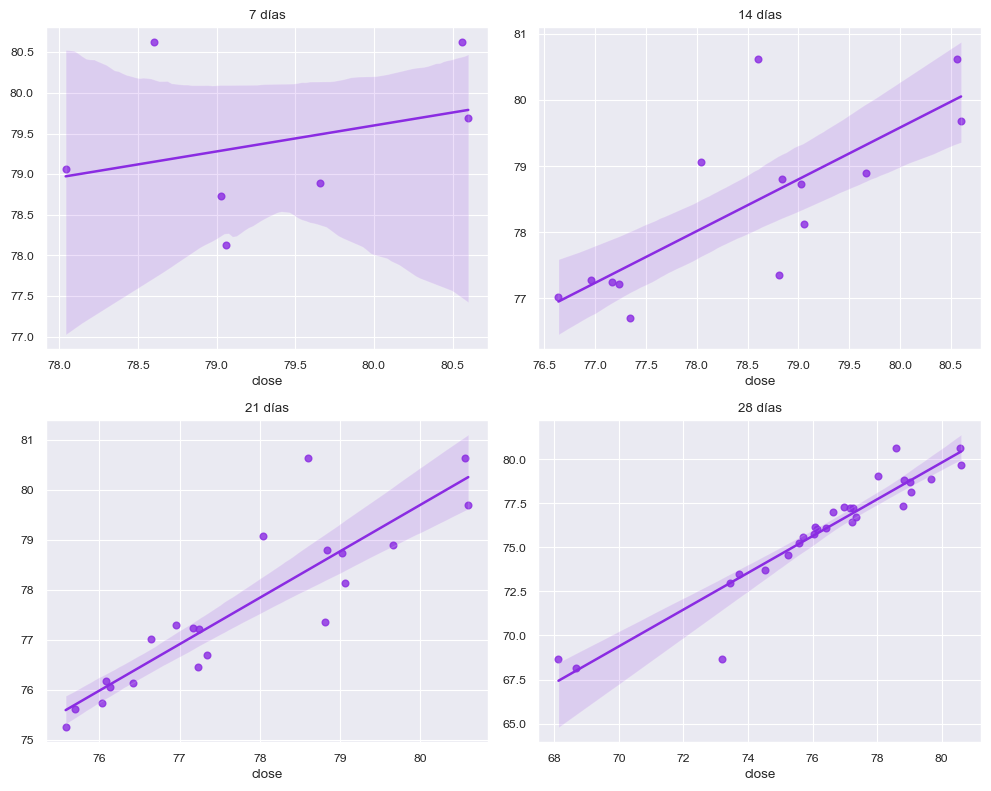

In [303]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

#(7 días)
sns.regplot(x=test_7, y=predict7_bic, color="#8A2BE2", ax=axs[0, 0])
axs[0, 0].set_title('7 días')

# (14 días)
sns.regplot(x=test_14, y=predict14_bic, color="#8A2BE2", ax=axs[0, 1])
axs[0, 1].set_title('14 días')

# (21 días)
sns.regplot(x=test_21, y=predict21_bic, color="#8A2BE2", ax=axs[1, 0])
axs[1, 0].set_title('21 días')

# (28 días)
sns.regplot(x=test_28, y=predict28_bic, color="#8A2BE2", ax=axs[1, 1])
axs[1, 1].set_title('28 días')
plt.tight_layout()
plt.show()

Al igual que las gráficas anteriores, en las predicciones de los 7 días no se observa ninguna correlación, pero en las graficas de 21 días y 28 días se observan valores un poco más agrupados, lo que podría significar algún tipo de correlación entre ellos.